In [ ]:
# Importing all the required libraries

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Parsing the data

df = pd.read_csv("/content/2023-12-15_15_41-results.csv", usecols = ['time', 'avgSnr'])

# Display the first five and last five rows of the dataset
pd.concat([df.head(), df.tail()])

,time,avgSnr
0,41.0,-5.390328
1,41.4,-5.389622
2,41.8,-5.405099
3,42.2,-5.399919
4,42.6,-5.419609
1063,466.2,-7.667514
1064,466.6,-7.927637
1065,467.0,-7.750394
1066,467.4,-7.519834
1067,467.8,-7.253272


In [ ]:
# Gaussian Noise layer
# Reference: https://discuss.pytorch.org/t/writing-a-simple-gaussian-noise-layer-in-pytorch/4694/4

class GaussianNoise(nn.Module):
  def __init__(self, sigma=0.1, is_relative_detach=True):
    super().__init__()
    self.sigma = sigma
    self.is_relative_detach = is_relative_detach
    self.noise = torch.tensor(0).to(device)

  def forward(self, x):
    if self.training and self.sigma != 0:
      scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma*x
      sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
      x = x + sampled_noise
    return x

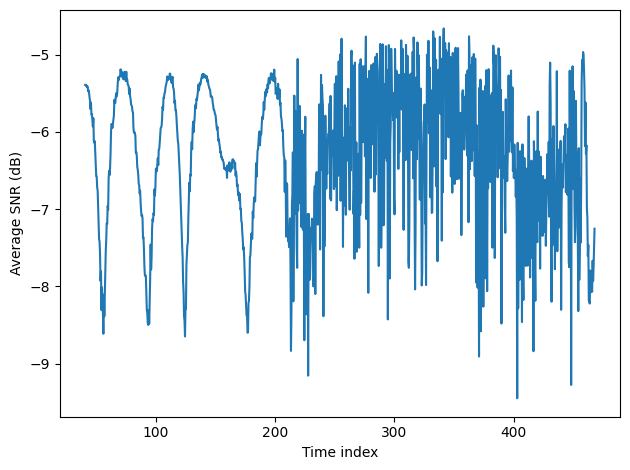

In [ ]:
time_index = df['time']
avgSnr = df['avgSnr']

# Plotting
plt.xlabel('Time index')
plt.ylabel('Average SNR (dB)')
plt.plot(time_index, avgSnr)
plt.tight_layout()
plt.show()

In [ ]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)

  df.set_index('time', inplace=True)

  for i in range(1, n_steps + 1):
    df[f'avgSnr(t-{i})'] = df['avgSnr'].shift(i)

  df.dropna(inplace=True)
  return df
lookback = 6
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

,avgSnr,avgSnr(t-1),avgSnr(t-2),avgSnr(t-3),avgSnr(t-4),avgSnr(t-5),avgSnr(t-6)
time,,,,,,,
43.4,-5.472568,-5.411899,-5.419609,-5.399919,-5.405099,-5.389622,-5.390328
43.8,-5.461143,-5.472568,-5.411899,-5.419609,-5.399919,-5.405099,-5.389622
44.2,-5.493098,-5.461143,-5.472568,-5.411899,-5.419609,-5.399919,-5.405099
44.6,-5.553611,-5.493098,-5.461143,-5.472568,-5.411899,-5.419609,-5.399919
45.0,-5.595636,-5.553611,-5.493098,-5.461143,-5.472568,-5.411899,-5.419609
...,...,...,...,...,...,...,...
466.2,-7.667514,-8.067894,-8.027450,-8.074116,-7.981298,-7.794020,-8.222220
466.6,-7.927637,-7.667514,-8.067894,-8.027450,-8.074116,-7.981298,-7.794020
467.0,-7.750394,-7.927637,-7.667514,-8.067894,-8.027450,-8.074116,-7.981298


In [ ]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[-5.47256815, -5.41189899, -5.4196088 , ..., -5.40509907,
        -5.38962164, -5.39032819],
       [-5.46114282, -5.47256815, -5.41189899, ..., -5.39991918,
        -5.40509907, -5.38962164],
       [-5.49309815, -5.46114282, -5.47256815, ..., -5.4196088 ,
        -5.39991918, -5.40509907],
       ...,
       [-7.75039441, -7.92763674, -7.66751421, ..., -8.02745008,
        -8.07411579, -7.9812976 ],
       [-7.51983359, -7.75039441, -7.92763674, ..., -8.06789404,
        -8.02745008, -8.07411579],
       [-7.25327178, -7.51983359, -7.75039441, ..., -7.66751421,
        -8.06789404, -8.02745008]])

In [ ]:
# Scaling the data in range (-1, 1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[ 0.66088634,  0.68622892,  0.68300839, ...,  0.68906936,
         0.69553456,  0.69523942],
       [ 0.6656589 ,  0.66088634,  0.68622892, ...,  0.6912331 ,
         0.68906936,  0.69553456],
       [ 0.65231059,  0.6656589 ,  0.66088634, ...,  0.68300839,
         0.6912331 ,  0.68906936],
       ...,
       [-0.29060202, -0.36463927, -0.25598149, ..., -0.40633307,
        -0.42582616, -0.38705436],
       [-0.19429268, -0.29060202, -0.36463927, ..., -0.42322723,
        -0.40633307, -0.42582616],
       [-0.08294509, -0.19429268, -0.29060202, ..., -0.25598149,
        -0.42322723, -0.40633307]])

In [ ]:
X = shifted_df_as_np[:, 1:] # all rows after zeroth column
y = shifted_df_as_np[:, 0] # all rows of just zeroth column

X.shape, y.shape

((1062, 6), (1062,))

In [ ]:
X = dc(np.flip(X, axis=1))
X

array([[ 0.69523942,  0.69553456,  0.68906936,  0.6912331 ,  0.68300839,
         0.68622892],
       [ 0.69553456,  0.68906936,  0.6912331 ,  0.68300839,  0.68622892,
         0.66088634],
       [ 0.68906936,  0.6912331 ,  0.68300839,  0.68622892,  0.66088634,
         0.6656589 ],
       ...,
       [-0.38705436, -0.42582616, -0.40633307, -0.42322723, -0.25598149,
        -0.36463927],
       [-0.42582616, -0.40633307, -0.42322723, -0.25598149, -0.36463927,
        -0.29060202],
       [-0.40633307, -0.42322723, -0.25598149, -0.36463927, -0.29060202,
        -0.19429268]])

In [ ]:
# Train-test split of 90-10
split_index = int(len(X) * 0.90)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((955, 6), (107, 6), (955,), (107,))

In [ ]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((955, 6, 1), (107, 6, 1), (955, 1), (107, 1))

In [ ]:
# Wrapping numpy elements in PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([955, 6, 1]),
 torch.Size([107, 6, 1]),
 torch.Size([955, 1]),
 torch.Size([107, 1]))

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [ ]:
# Wrap datasets into dataloaders
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([16, 6, 1]) torch.Size([16, 1])


In [ ]:
# Fun part
class LSTM(nn.Module):
  '''
  input_size = no. of features
    in our case 1 because we are only looking for `avgSnr`
  hidden_size = no. of hidden layers
  explanation for num_stacked_layers:
    higher stacked layers = higher complexity of the LSTM model
  '''

  def __init__(self, input_size, hidden_size, num_stacked_layers, sigma=0.1):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    # self.noise = GaussianNoise(sigma=sigma) # Add noise layer to the network
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                        batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  # Forward function
  def forward(self, x):
    batch_size = x.size(0)
    # x = x.float()
    # x = self.noise(x) if self.training else x
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1, 4, 1, sigma=0.1)
model.to(device)

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
# Training function
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 50 == 0:
            avg_loss_across_batches = running_loss / 50
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

# Validation function
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [ ]:
learning_rate = 0.0001
num_epochs = 10000
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 1, Loss: 0.004
Batch 51, Loss: 0.191

Val Loss: 0.261
***************************************************

Epoch: 2
Batch 1, Loss: 0.004
Batch 51, Loss: 0.193

Val Loss: 0.259
***************************************************

Epoch: 3
Batch 1, Loss: 0.005
Batch 51, Loss: 0.196

Val Loss: 0.259
***************************************************

Epoch: 4
Batch 1, Loss: 0.005
Batch 51, Loss: 0.198

Val Loss: 0.260
***************************************************

Epoch: 5
Batch 1, Loss: 0.003
Batch 51, Loss: 0.199

Val Loss: 0.259
***************************************************

Epoch: 6
Batch 1, Loss: 0.002
Batch 51, Loss: 0.196

Val Loss: 0.259
***************************************************

Epoch: 7
Batch 1, Loss: 0.005
Batch 51, Loss: 0.194

Val Loss: 0.260
***************************************************

Epoch: 8
Batch 1, Loss: 0.005
Batch 51, Loss: 0.195

Val Loss: 0.258
***************************************************

Epoch: 9
Batch 1, Loss: 

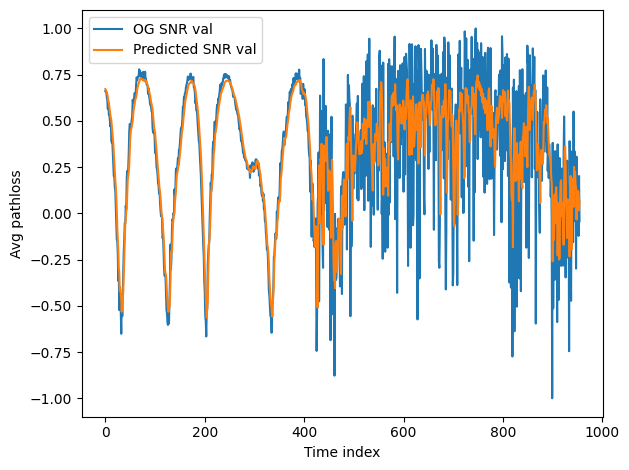

In [ ]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='OG SNR val')
plt.plot(predicted, label='Predicted SNR val')
plt.xlabel('Time index')
plt.ylabel('Avg pathloss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
# train_predictions

In [ ]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
# new_y_train

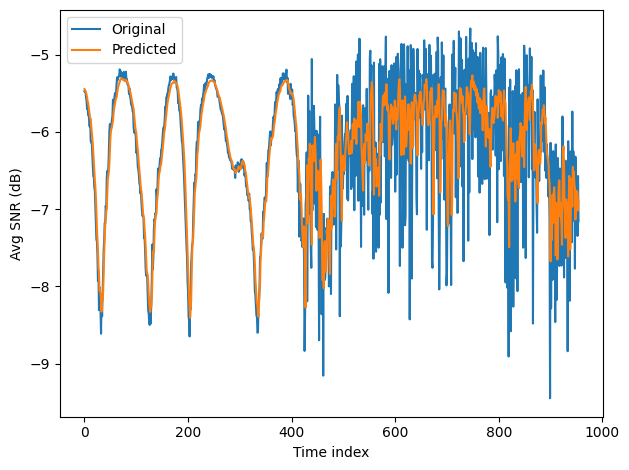

In [ ]:
plt.plot(new_y_train, label='Original')
plt.plot(train_predictions, label='Predicted')
plt.xlabel('Time index')
plt.ylabel('Avg SNR (dB)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([-6.9747156 , -7.14819387, -6.99990203, -7.11033775, -6.90354465,
       -7.09382017, -7.1130354 , -7.01127716, -6.61934279, -6.45327569,
       -6.53075566, -6.41117186, -6.6202853 , -6.16288987, -5.7149721 ,
       -5.62282254, -5.91203101, -6.5179106 , -6.68486613, -7.07549127,
       -6.77179714, -6.27844399, -6.23332232, -6.39439394, -6.8346218 ,
       -7.038745  , -7.17483104, -7.22871438, -6.10585598, -6.35033125,
       -6.52974141, -6.79964233, -7.0717696 , -6.75239799, -6.68701331,
       -6.51302642, -6.3054386 , -6.79889756, -7.05801631, -6.89211937,
       -6.65458962, -6.61059895, -6.4958774 , -6.32979813, -6.30609562,
       -6.24762712, -6.11426341, -6.2763652 , -6.35052453, -6.46295693,
       -6.62494634, -6.61236922, -6.32917671, -6.67663234, -7.17042074,
       -6.27815319, -6.3624461 , -6.15560677, -6.67159888, -6.88868108,
       -6.47872588, -5.82601169, -5.97317127, -5.86566144, -5.7492899 ,
       -5.96978057, -6.42796191, -6.65801207, -6.26181462, -6.23

In [ ]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([-7.28916831, -6.76153977, -7.29602971, -6.61807662, -7.47467561,
       -7.0180998 , -6.85679086, -6.28857364, -6.37264581, -6.79922487,
       -6.12854959, -7.09730155, -5.40453881, -5.10267612, -5.62155116,
       -7.54280873, -8.19876398, -6.0989966 , -7.4665944 , -6.35865572,
       -5.92418017, -6.31892042, -6.69197051, -7.77869147, -6.89527497,
       -7.13656991, -7.23282979, -5.21355746, -7.54507531, -6.47342279,
       -7.13509886, -7.24073688, -6.22504059, -6.87810267, -6.24210611,
       -6.11651922, -8.3033754 , -6.94587149, -6.5241691 , -6.41770334,
       -6.72135887, -6.40537838, -6.05541999, -6.3685724 , -6.15318858,
       -5.90079579, -6.78126298, -6.30622547, -6.60619761, -6.81064272,
       -6.45724257, -5.95719271, -7.68579128, -7.75231464, -5.20818728,
       -6.89233993, -5.75400242, -9.27663662, -6.49505792, -5.83405119,
       -5.15077961, -6.73774724, -5.46718367, -5.54415702, -6.94524797,
       -7.42709033, -6.42183154, -5.59816464, -6.46410499, -6.26

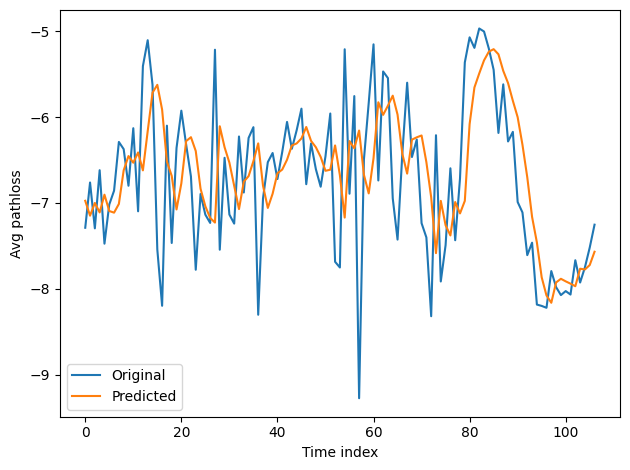

In [ ]:
plt.plot(new_y_test, label='Original')
plt.plot(test_predictions, label='Predicted')
plt.xlabel('Time index')
plt.ylabel('Avg pathloss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Saving the model
import os
model_path = os.path.join("/content/", "final_model.pth")
torch.save(model.state_dict(), model_path)